In [24]:
import json
from pathlib import Path 
commits = json.loads(Path('../models/spark/logs/commits.json').read_text())
len(commits)

10841

In [25]:
import itertools
import re
parse_path = re.compile(f"[a-zA-Z0-9/\-]+/(org\/apache\/spark\/[a-zA-Z0-9/\-]+)\.scala")

corr_map = {}

for _, _, files in commits:
    group = []
    for f in files:
        qs = parse_path.search(f)
        if qs:
            group.append(qs.group(1).replace('/', '.'))
            
    for x, y in filter(lambda p: p[0] != p[1], itertools.product(group, group)):
        if x not in corr_map:
            corr_map[x] = {}
        if y not in corr_map[x]:
            corr_map[x][y] = 0
            
        corr_map[x][y] += 1
        
len(corr_map)

4123

In [26]:
freq_thres = 8

corr_graph = {}
for k, v in corr_map.items():
   corr_graph[k] = list(map(lambda x: x[0], filter(lambda x: x[1] > freq_thres, v.items())))

In [27]:
targets = ['org.apache.spark.sql.DataFrameSuite']

from ptesting import depgraph
cg, _ = depgraph.select_subgraph(targets, corr_graph, depth=5)
len(cg)

285

In [28]:
node_id_to_name = {}
name_to_node_id = {}
corr_edge_list = []
next_id = 0

for src, dsts in cg.items():
    if src not in name_to_node_id:
        name_to_node_id[src] = next_id
        node_id_to_name[next_id] = src
        next_id += 1
        
    src_id = name_to_node_id[src]
    for dst in dsts:
        if dst not in name_to_node_id:
            name_to_node_id[dst] = next_id
            node_id_to_name[next_id] = dst
            next_id += 1

        corr_edge_list.append((src_id, name_to_node_id[dst]))
        
len(corr_edge_list)

1625

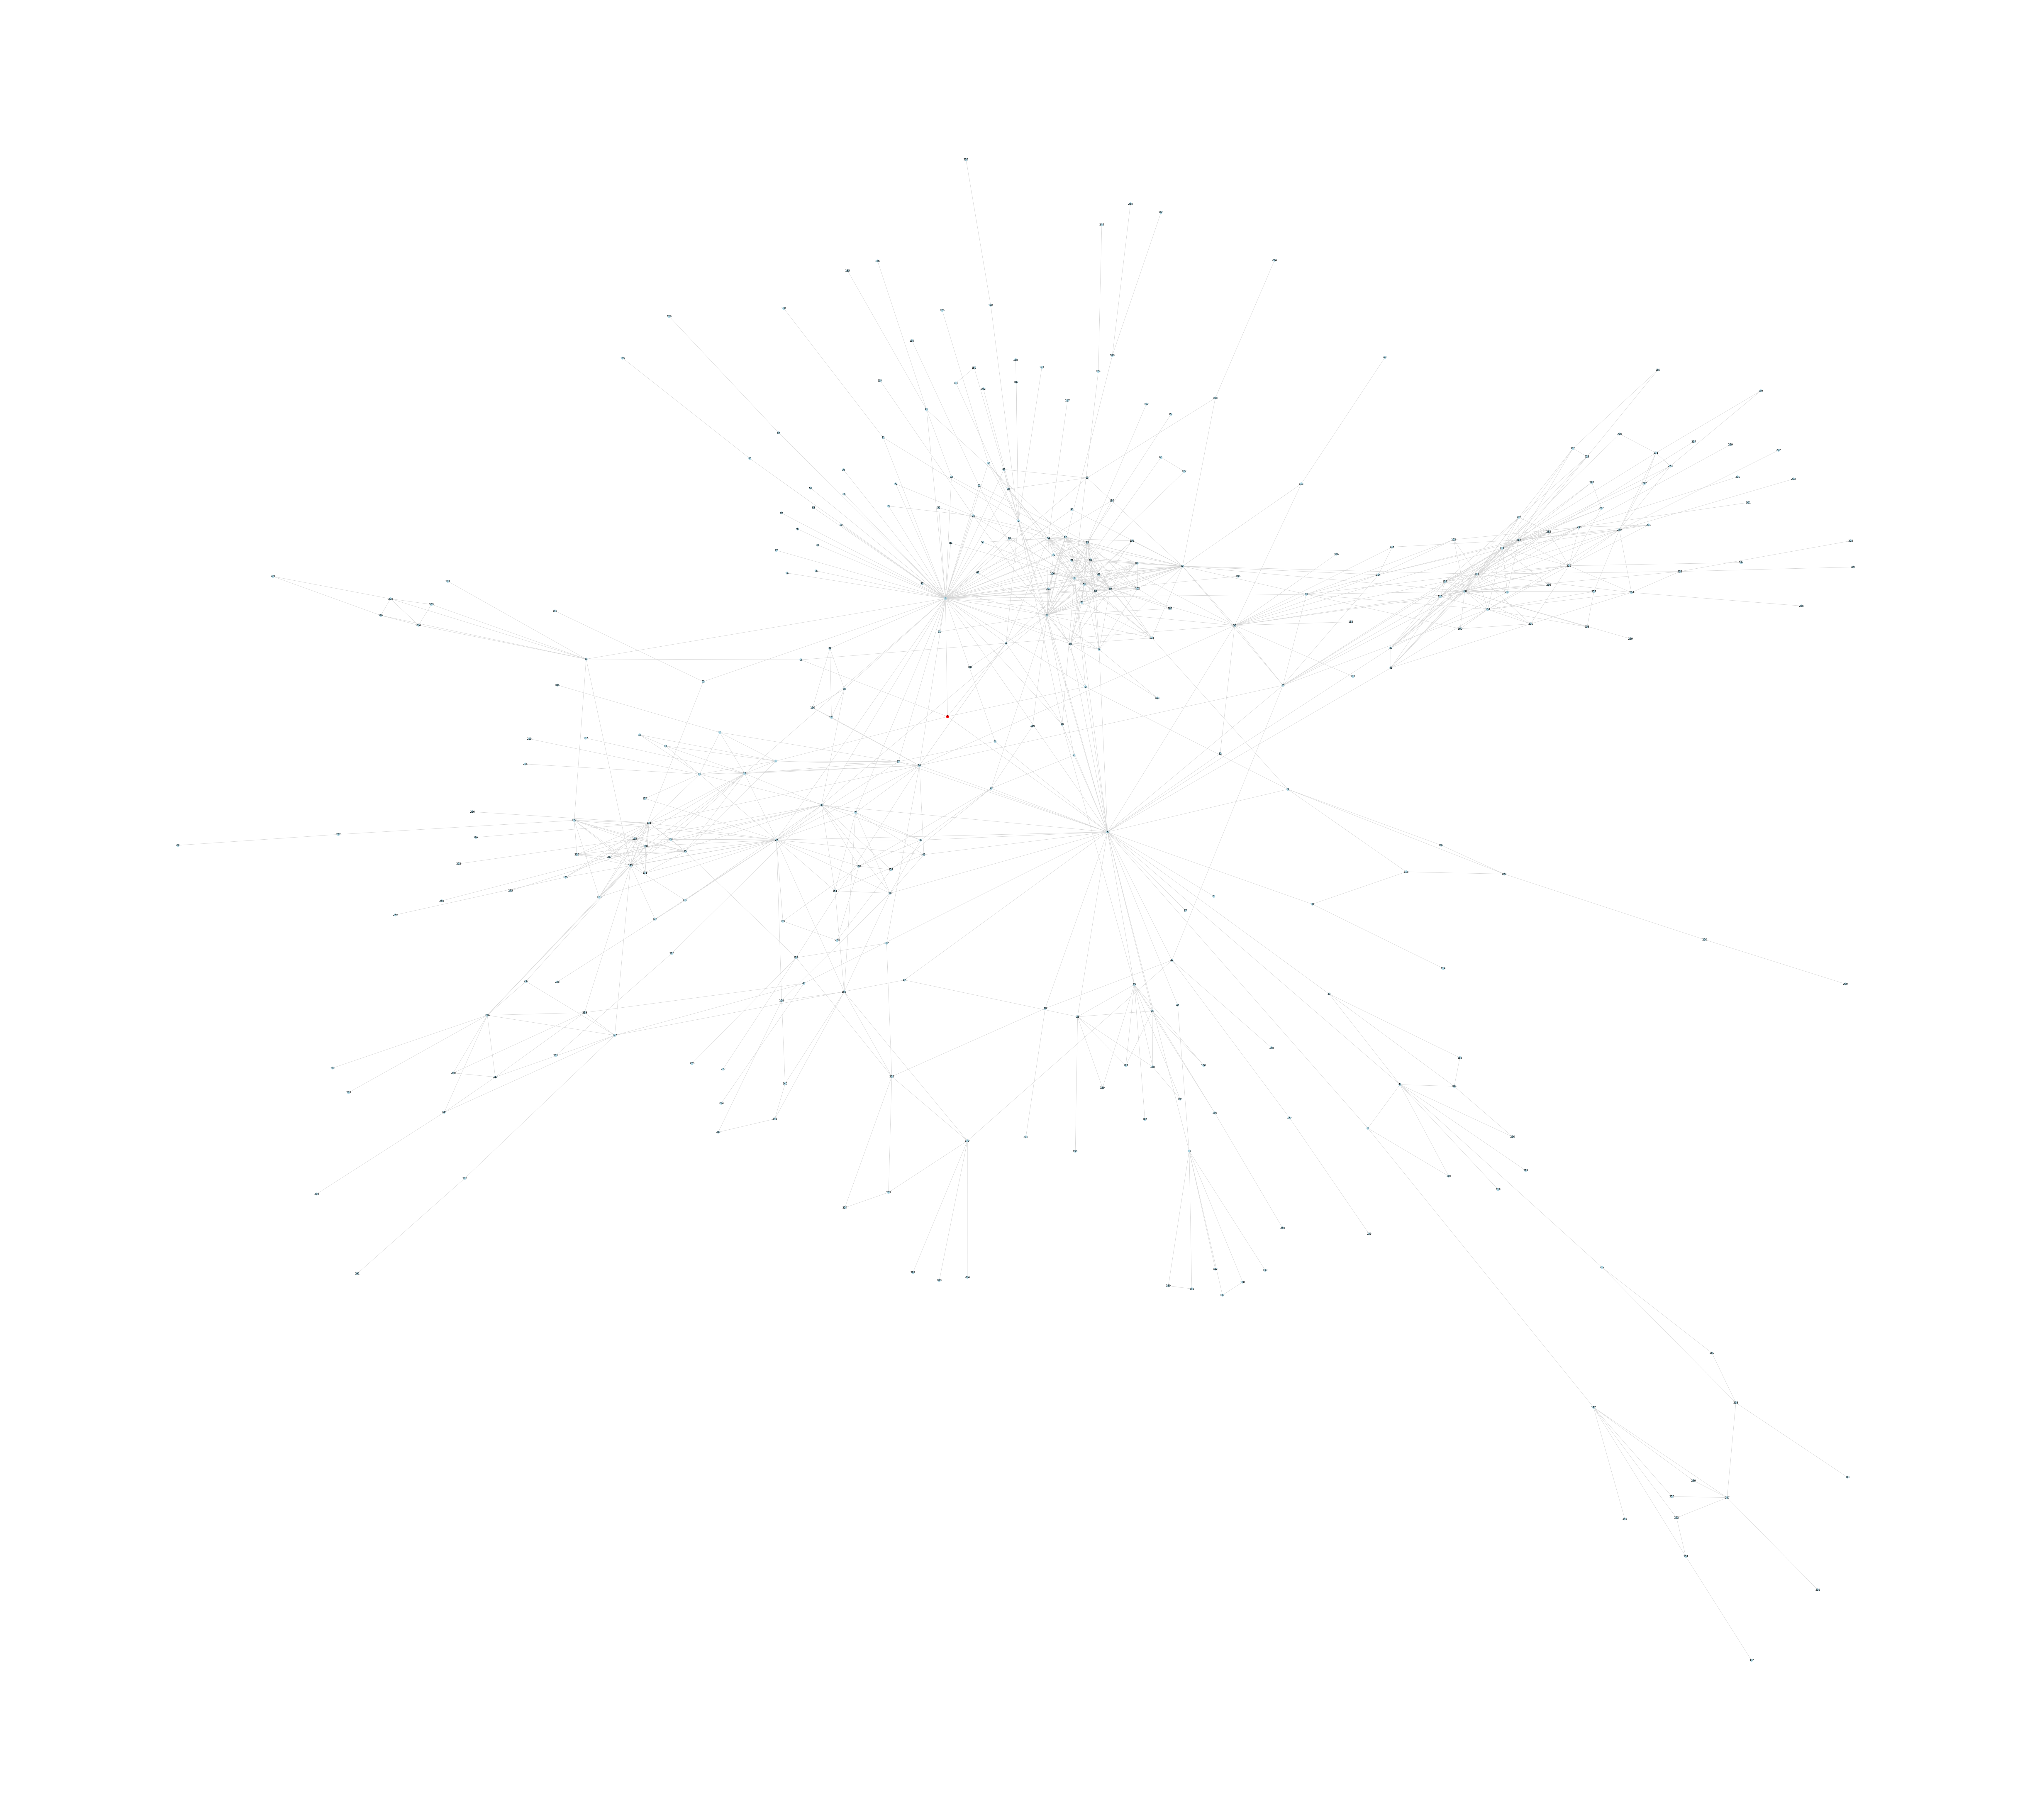

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(96, 86))

# dot, neato, fdp, sfdp, twopi, circo
g = nx.Graph()
g.add_edges_from(corr_edge_list)
pos = nx.nx_pydot.graphviz_layout(g, prog='sfdp')
target_nodes = list(map(lambda x: name_to_node_id[x], targets))
node_colors = ['red' if n in target_nodes else 'lightblue' for n in g.nodes()]
nx.draw(g, with_labels=True, font_size=9, pos=pos, node_shape='.', node_color=node_colors, edge_color='lightgray')